In [5]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_notebook
import pickle
import glob
#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *

importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [2]:
datasets = ['ecoTest', 'ecoLennyTest']
models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
#models  = ['ego', 'saycam']
imagelists = {}
activations = {}
for dataset in datasets:
    path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

    imagelists[dataset] = {}
    activations[dataset] = {}
    for model in models:
        with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
            imagelists[dataset][model] = [line.strip() for line in f.readlines()]
        activations[dataset][model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

    #### Normalize vectors
    for model in models:
        norms = np.linalg.norm(activations[dataset][model], axis=1, keepdims=True)
        activations[dataset][model] = activations[dataset][model]/norms # normalization


In [3]:
listcat = {}
for dataset in datasets:
    ### check if images were shown in the same order
    assert imagelists[dataset]['ego'] == imagelists[dataset]['saycam']
    imagelist = imagelists[dataset]['ego']  # since they are the same, only consider one list

    #### check if each category has the same number of images and list all categories in listcats
    count = 0
    cat = ''
    listcat[dataset] = list()
    for i, imgp in enumerate(imagelist):
        current_cat = imgp.split('/')[-2]
        if i == 0:
            cat = current_cat
            listcat[dataset].append(current_cat)
        if cat != current_cat:
            cat = current_cat
            listcat[dataset].append(current_cat)
            count = 1
        else:
            count += 1

    nb_per_cat = count  # in val, 50 images per cate

    nb_per_cat

    ### reshape activations according to include categories
    cat_activations = activations.copy()

    for model in models:
        shape = activations[dataset][model].shape
        cat_activations[dataset][model] = activations[dataset][model].reshape(-1, nb_per_cat, shape[-1])

In [4]:

### Compute representational compactness for each category and model
compactness = {}
compact_categories = {}
for dataset in datasets:
    compactness[dataset] , compact_categories[dataset] = max_rsa.compute_compactness(cat_activations[dataset], models, listcat[dataset], measure = 'Fisher_discriminant')


ego
saycam
imagenet
supervised
random
resnet
ego
saycam
imagenet
supervised
random
resnet


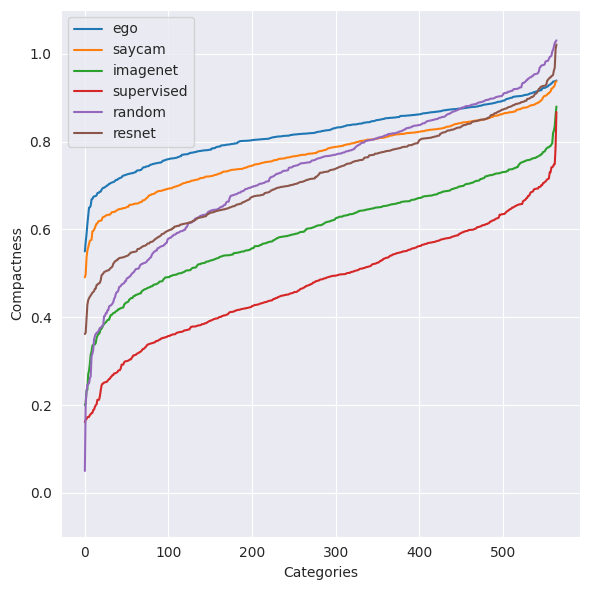

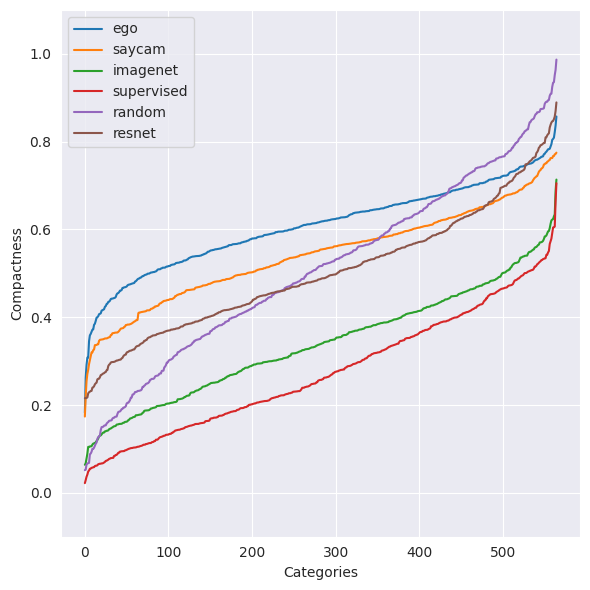

In [6]:
fig_compactness = {}; ax_compactness = {}
for dataset in datasets:
    fig_compactness[dataset], ax_compactness[dataset] = max_rsa.plot_stats_one(compactness[dataset],models,  ['Categories', 'Compactness'], savename=f'Fisher_descriminant_allmodels_{dataset}.png')

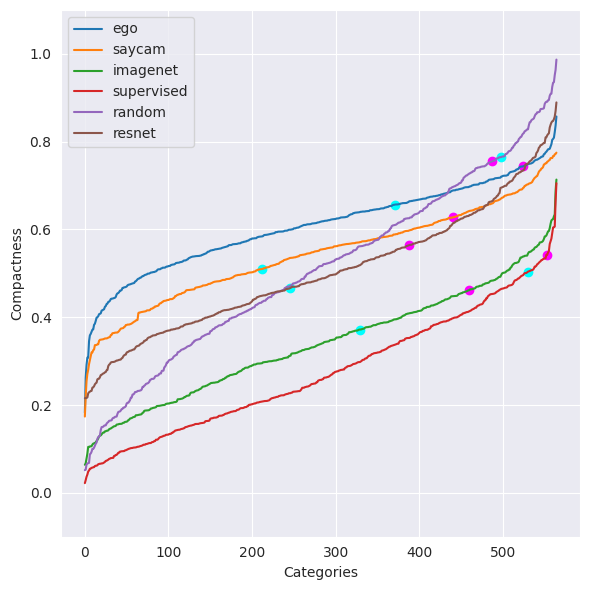

In [7]:
for dataset in datasets:
    for model in models:
        index = np.array(range(len(compact_categories[dataset][model])))[compact_categories[dataset][model] == '0001_man']
        ax_compactness[dataset].scatter(index,compactness[dataset][model][index], color = 'magenta')
        index = np.array(range(len(compact_categories[dataset][model])))[compact_categories[dataset][model] == '0020_woman']
        ax_compactness[dataset].scatter(index,compactness[dataset][model][index], color = 'cyan')

fig_compactness[dataset]

In [8]:
for dataset in datasets:
    print(dataset)
    for model in models:
        print(f'{model}')
        print(compact_categories[dataset][model][:12])

ecoTest
ego
['1073_fireworks' '0156_moon' '0089_bus' '2144_newsstand' '0005_house'
 '2400_geyser' '0082_kitchen' '1634_earpiece' '0907_lasagna'
 '2098_odometer' '0617_taco' '1081_thermostat']
saycam
['1073_fireworks' '0089_bus' '0082_kitchen' '2144_newsstand' '0005_house'
 '2400_geyser' '0907_lasagna' '2112_photocopier' '0882_scoreboard'
 '0137_train' '1043_mall' '0149_truck']
imagenet
['0847_jaguar' '2098_odometer' '1129_zebra' '2400_geyser' '2186_cheetah'
 '0764_gondola' '1892_panda' '0132_tiger' '0089_bus' '0306_warthog'
 '0857_waterfall' '1787_koala']
supervised
['1011_typewriter' '1829_blimp' '0678_hourglass' '1129_zebra'
 '2186_cheetah' '0909_flea' '0764_gondola' '2017_giraffe' '0721_hedgehog'
 '2400_geyser' '0306_warthog' '2098_odometer']
random
['1073_fireworks' '0670_pliers' '0156_moon' '0047_fire' '1800_silverfish'
 '1123_scissors' '0488_iceberg' '1634_earpiece' '1687_parachute'
 '2555_manatee' '0093_pizza' '0857_waterfall']
resnet
['0082_kitchen' '0089_bus' '2144_newsstand' 

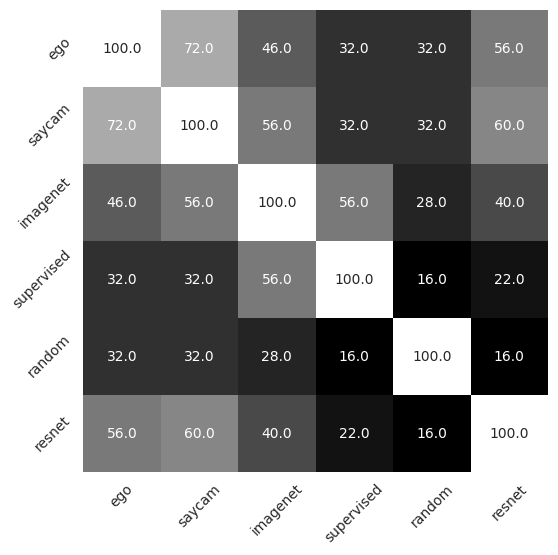

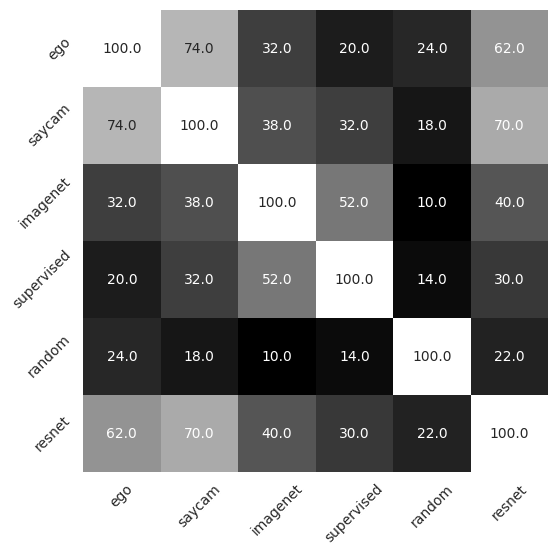

In [12]:
def check_list_similarity(list1, list2):
    '''Checks if two lists contain the same elements, regardless of order,
    and calculates the proportion of common elements.'''
    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1 & set2  # Intersection of sets
    proportion = (len(common_elements) / max(len(set1), len(set2))) * 100 if max(len(set1), len(set2)) > 0 else 0
    return proportion

import seaborn as sns


model_overlap_matrix = {}
for dataset in datasets:
    model_overlap_matrix[dataset] = np.zeros((len(models), len(models)))

    for m1, model1 in enumerate(models):
        for m2, model2 in enumerate(models):
            model_overlap_matrix[dataset][m1,m2] = check_list_similarity(compact_categories[dataset][model1][:50],compact_categories[dataset][model2][:50])
    plt.figure(figsize=(6, 6))
    plt.rcParams['axes.grid'] = False
    # Replace the plt.imshow() section with:
    sns.heatmap(model_overlap_matrix[dataset],
            annot=True, fmt='.1f', cmap='grey',
            xticklabels=models, yticklabels=models, cbar=False)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    #plt.imshow(model_overlap_matrix[dataset], cmap = 'grey')
    #plt.xticks(np.arange(len(models)), models, rotation = 45)
    #plt.yticks(np.arange(len(models)), models, rotation = 45)
    plt.show()

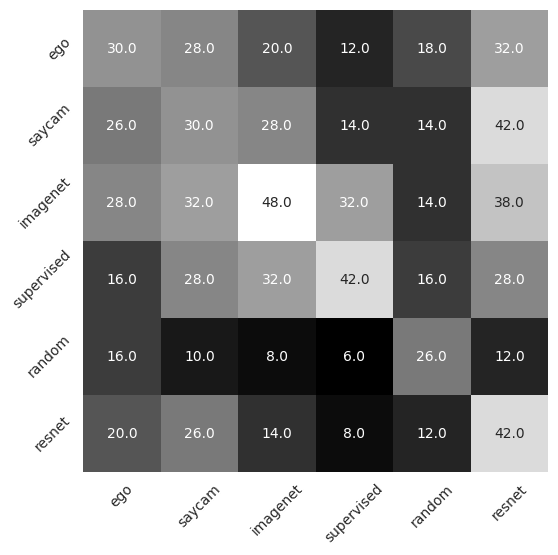

In [15]:
### Check overlap between the 2 datasets
dataset_overlap_matrix = np.zeros((len(models), len(models)))

for m1, model1 in enumerate(models):
    for m2, model2 in enumerate(models):
        dataset_overlap_matrix[m1,m2] = check_list_similarity(compact_categories[datasets[0]][model1][:50],compact_categories[datasets[1]][model2][:50])
plt.figure(figsize=(6, 6))
plt.rcParams['axes.grid'] = False
# Replace the plt.imshow() section with:
sns.heatmap(dataset_overlap_matrix,
        annot=True, fmt='.1f', cmap='grey',
        xticklabels=models, yticklabels=models, cbar=False)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
#plt.imshow(model_overlap_matrix[dataset], cmap = 'grey')
#plt.xticks(np.arange(len(models)), models, rotation = 45)
#plt.yticks(np.arange(len(models)), models, rotation = 45)
plt.show()

In [10]:
nb_categories = len(listcat)
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(compact_categories, compactness, nb_categories, listcat, models = ['saycam', 'resnet'], nb_considered_categories = 12, compactness_diff_measure = 'normalizedDiff')

12
The 12 categories leading to the max differences between saycam and resnet are ['0005_house' '0052_fish' '0071_camera' '0116_flower' '0117_ring'
 '0593_butterfly' '0065_tree' '1846_spareribs' '0982_tortilla'
 '0068_clock' '0513_acorn' '1048_potato']
Category numbers are [  1  13  20  36  37 198  17 468 289  18 185 310]
With differences in compactness of  [ 0.8947907   0.85127604  0.82506657  0.68673277  0.5943679  -0.5872824
  0.5853878  -0.5622632  -0.5538664   0.54549885  0.53942156  0.5320416 ]
